In [10]:
import os
import numpy as np
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Paths for dataset folders
input_dataset = "/kaggle/input/compa-medical-data-dataset2/compa_multimodal_dataset"
output_dataset = "/kaggle/working/dataset2"

# Ensure the output dataset directory exists
if os.path.exists(output_dataset):
    shutil.rmtree(output_dataset)  # Remove old dataset if it exists
os.makedirs(output_dataset)

# Define basic augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

# Required class names
list1=os.listdir(input_dataset)
#required_classes = ["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"]

# Process each class folder
for class_name in tqdm(list1, desc="Processing Classes"):
    class_path = os.path.join(input_dataset, class_name)
    
    if not os.path.exists(class_path):
        print(f"❌ Skipping {class_name}, folder not found.")
        continue
    
    # Create the new output class folder
    output_class_path = os.path.join(output_dataset, class_name)
    os.makedirs(output_class_path, exist_ok=True)
    
    # Load all images from the class folder
    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('png', 'jpg', 'jpeg'))]
    
    # Generate exactly 1000 augmented images
    num_images_generated = 0
    image_index = 0
    
    with tqdm(total=500, desc=f"Augmenting {class_name}", leave=False) as pbar:
        while num_images_generated < 500:
            img_path = images[image_index % len(images)]  # Loop through existing images
            img = load_img(img_path)  # Load image
            img = img.resize((100, 100))  # Resize to 100x100
            img_array = img_to_array(img)  # Convert to array
            img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions
            
            # Generate augmented images
            aug_iter = datagen.flow(img_array, batch_size=1)
            for _ in range(min(500 - num_images_generated, 5)):  # Generate up to 5 images per iteration
                augmented_img = array_to_img(next(aug_iter)[0])  # Convert back to image
                augmented_img = augmented_img.resize((100, 100))  # Resize again to ensure size
                save_path = os.path.join(output_class_path, f"aug_{num_images_generated}.png")
                augmented_img.save(save_path)  # Save image
                num_images_generated += 1
                pbar.update(1)  # Update progress bar
            
            image_index += 1  # Move to the next image

print("✅ Data augmentation complete. Augmented dataset saved in 'dataset7'.")


Processing Classes: 100%|██████████| 4/4 [00:12<00:00,  3.15s/it]           

✅ Data augmentation complete. Augmented dataset saved in 'dataset7'.


In [11]:
!python --version

Python 3.10.12


In [12]:
import cv2
import os
import numpy as np
from tqdm import tqdm

def preprocess_and_save_with_subclasses2(input_dir, output_dir, target_size=(100,100)):
    """
    Preprocess images from input directory (with subclasses) and save to output directory.
    - Maintains the original folder structure (subclasses).
    - Applies image preprocessing: grayscale, CLAHE, Gaussian blur, Canny edge detection, and overlays edges in red.
    """
    # Initialize CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    list1=os.listdir(input_dir)

    for subclass in list1:
        subclass_path = os.path.join(input_dir, subclass)
        if not os.path.isdir(subclass_path):
            continue  # Skip files, only process folders
        
        # Create corresponding subclass folder in the output directory
        output_subclass_path = os.path.join(output_dir, subclass)
        if not os.path.exists(output_subclass_path):
            os.makedirs(output_subclass_path)
        
        # Process each image in the subclass folder
        for image_name in tqdm(os.listdir(subclass_path), desc=f"Processing {subclass}"):
            image_path = os.path.join(subclass_path, image_name)
            image = cv2.imread(image_path)
            
            if image is None:
                continue  # Skip invalid files
            
            # Resize image
            image = cv2.resize(image, target_size)
            
            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            # Apply CLAHE for contrast enhancement
            clahe_enhanced = clahe.apply(gray)
            
            # Apply Gaussian blur to reduce noise
            blurred = cv2.GaussianBlur(clahe_enhanced, (5, 5), 0)
            
            # Apply Canny edge detection
            edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
            
            # Create an RGB edge map (edges in red)
            edges_colored = np.zeros_like(image)  # Create a black RGB image
            edges_colored[:, :, 2] = edges  # Set red channel to edges
            
            # Overlay the edges onto the original image
            combined = cv2.addWeighted(image, 0.8, edges_colored, 0.5, 0)
            
            # Save the processed image to the corresponding output folder
            output_path = os.path.join(output_subclass_path, image_name)
            cv2.imwrite(output_path, combined)


In [13]:
# Define input and output directories
input_directory = '/kaggle/working/dataset2'  # Contains subclass folders
output_directory = '/kaggle/working/dataset_preprocessed'  # Preprocessed images will be saved here

# Run preprocessing
preprocess_and_save_with_subclasses2(input_directory, output_directory)


Processing retina_data: 100%|██████████| 500/500 [00:01<00:00, 493.93it/s]


In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2 
import os
import random

In [15]:
import os
import cv2
import numpy as np

def load_dataset(path_dataset, target_size=(100,100)): 
    dataset = []
    labels = []

    # Iterate over all folders in dataset_path
    for label in os.listdir(path_dataset):
        class_path = os.path.join(path_dataset, label)

        # check if the directory exists
        if os.path.isdir(class_path):
            # Initialize a counter for images in each class
            images_counter = 0
            
            # Iterate over all images in folder/class
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)

                # Load image with OpenCV
                image = cv2.imread(image_path)

                # Check if the image was loaded successfully
                if image is not None:
                    # Resize the image
                    image = cv2.resize(image, target_size)
                    # Get image dimensions
                    (h, w) = image.shape[:2]
                    
                    # Step 1: Apply random rotation between 0 to 5 degrees
                    angle = random.uniform(0, 5)  # Random angle between 0 and 5 degrees
                    center = (w // 2, h // 2)  # Center of the image
                    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)  # Rotation matrix
                    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
                    
                    # Step 2: Apply right-to-left flip
                    image = cv2.flip(rotated_image, 1)  # Flip horizontally
                    # Add image and label to dataset
                    dataset.append(image)
                    labels.append(label)


                else:
                    print(f"Error loading image: {image_path}")

    return np.array(dataset), np.array(labels)

dataset_path = "/kaggle/working/dataset_preprocessed"
dataset, labels = load_dataset(dataset_path) 

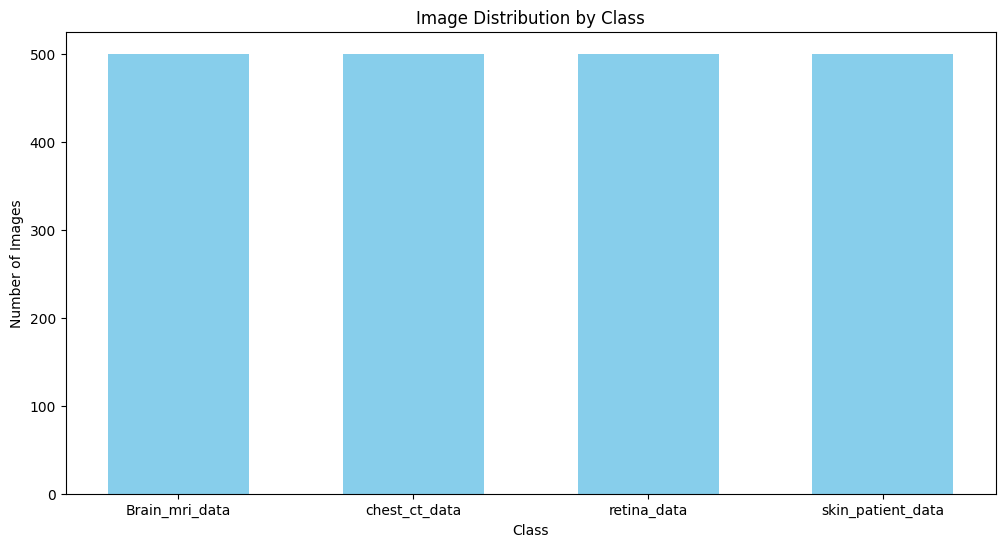

In [16]:
unique_labels, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique_labels, counts))

fig, ax = plt.subplots(figsize=(12, 6)) 
bars = ax.bar(class_counts.keys(), class_counts.values(), color='skyblue', width=0.6)  

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Image Distribution by Class')

plt.show()

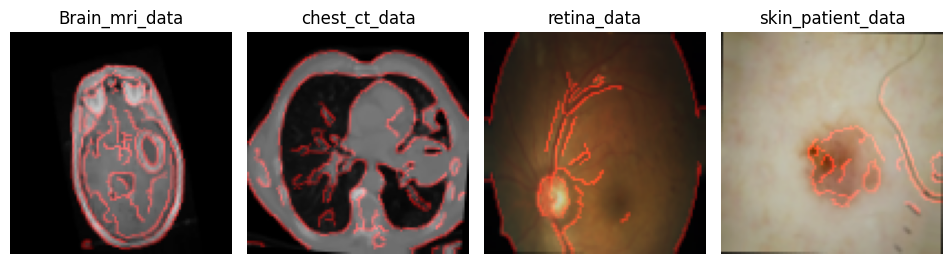

In [17]:
import random
import matplotlib.pyplot as plt

def show_samples(dataset, labels, classes, num_samples):
    plt.figure(figsize=(12, 6))
    
    for i, class_name in enumerate(classes[:num_samples]):  # Show only the first num_samples classes
        indices_class = np.where(labels == class_name)[0]
        sample_index = random.choice(indices_class)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(dataset[sample_index], cv2.COLOR_BGR2RGB))
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


unique_classes = np.unique(labels)
show_samples(dataset, labels, unique_classes, num_samples=5)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels into numbers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)



X_train, X_temp, y_train, y_temp = train_test_split(dataset, encoded_labels, test_size=0.2, random_state=42)


X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


def preprocess_image(image):
    resized_image = cv2.resize(image, (100,100))
    
    normalized_image = resized_image / 255.0
    return normalized_image


X_train = np.array([preprocess_image(image) for image in X_train])
X_test = np.array([preprocess_image(image) for image in X_test])
X_val = np.array([preprocess_image(image) for image in X_val])


print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1600, 100, 100, 3)
Shape of X_val: (200, 100, 100, 3)
Shape of X_test: (200, 100, 100, 3)
Shape of y_train: (1600,)
Shape of y_val: (200,)
Shape of y_test: (200,)


In [19]:
# Print label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
for label, code in label_mapping.items():
    print(f"{label} => {code}")

Label Mapping:
Brain_mri_data => 0
chest_ct_data => 1
retina_data => 2
skin_patient_data => 3


In [20]:
!pip install efficientnet

  Obtaining dependency information for efficientnet from https://files.pythonhosted.org/packages/53/97/84f88e581d6ac86dcf1ab347c497c4c568c38784e3a2bd659b96912ab793/efficientnet-1.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for keras-applications<=1.0.8,>=1.0.7 from https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 693.1 kB/s eta 0:00:000:00:01


In [21]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop
import numpy as np

# Define the number of classes
num_classes = len(np.unique(labels))

# Load MobileNet without the top classification layers
mobilenet_model = MobileNet(input_shape=(100, 100, 3), include_top=False, weights='imagenet')

# Create a new model
inputs = mobilenet_model.input
conv_output = mobilenet_model.layers[-1].output  # Last conv layer output

x = GlobalAveragePooling2D()(conv_output)
x = Dense(128, kernel_regularizer=l1(0.0001), activation='relu')(x)
x = BatchNormalization(renorm=True)(x)
x = Dropout(0.3)(x)

x = Dense(64, kernel_regularizer=l1(0.0001), activation='relu')(x)
x = BatchNormalization(renorm=True)(x)
x = Dropout(0.3)(x)

x = Dense(32, kernel_regularizer=l1(0.0001), activation='relu')(x)
x = BatchNormalization(renorm=True)(x)
x = Dropout(0.3)(x)

# Final output layer
outputs = Dense(units=num_classes, activation='softmax')(x)

# Compile the model
model = models.Model(inputs=inputs, outputs=outputs)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
custom_optimizer = RMSprop(learning_rate=0.0001)

model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))


17225924/17225924 [==============================] - 1s 0us/step
Epoch 1/30
50/50 [==============================] - 14s 38ms/step - loss: 1.4963 - accuracy: 0.6569 - val_loss: 0.8884 - val_accuracy: 0.9250
Epoch 2/30
50/50 [==============================] - 1s 23ms/step - loss: 0.9138 - accuracy: 0.9013 - val_loss: 0.6433 - val_accuracy: 0.9900
Epoch 3/30
50/50 [==============================] - 1s 23ms/step - loss: 0.7770 - accuracy: 0.9500 - val_loss: 0.5900 - val_accuracy: 1.0000
Epoch 4/30
50/50 [==============================] - 1s 23ms/step - loss: 0.7130 - accuracy: 0.9769 - val_loss: 0.5776 - val_accuracy: 1.0000
Epoch 5/30
50/50 [==============================] - 1s 23ms/step - loss: 0.6696 - accuracy: 0.9869 - val_loss: 0.5687 - val_accuracy: 1.0000
Epoch 6/30
50/50 [==============================] - 1s 23ms/step - loss: 0.6460 - accuracy: 0.9900 - val_loss: 0.5620 - val_accuracy: 1.0000
Epoch 7/30
50/50 [==============================] - 1s 23ms/step - loss: 0.6343 - accura

In [22]:
# Save the weights of the model to a file
model.save_weights('mobilenet+model.h5')

In [46]:
# Save the weights of the model to a file
#model.save_weights('coatnet_skin_cancer.h5')

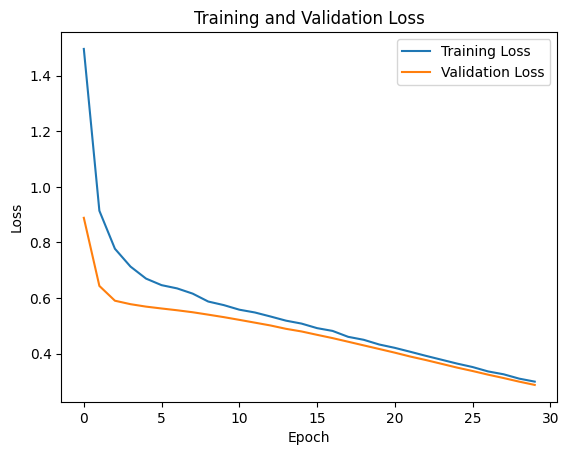

In [23]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

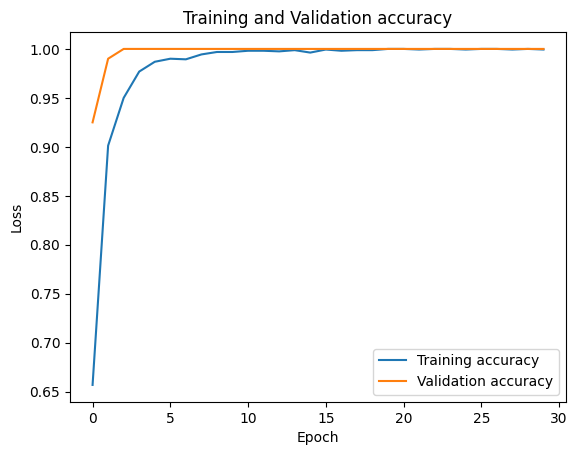

In [24]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

7/7 [==============================] - 0s 7ms/step
Test Accuracy: 1.0000


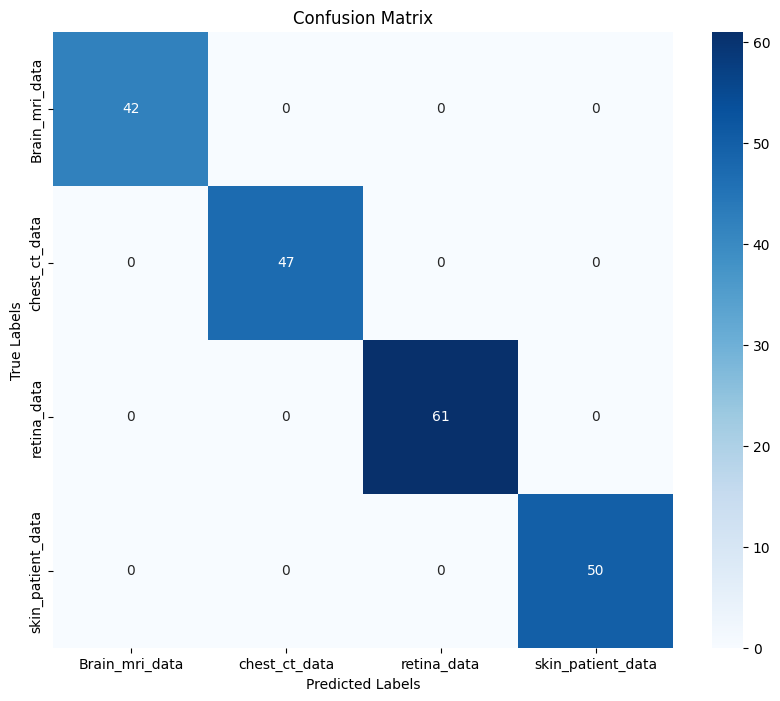

Classification Report:
                   precision    recall  f1-score   support

   Brain_mri_data     1.0000    1.0000    1.0000        42
    chest_ct_data     1.0000    1.0000    1.0000        47
      retina_data     1.0000    1.0000    1.0000        61
skin_patient_data     1.0000    1.0000    1.0000        50

         accuracy                         1.0000       200
        macro avg     1.0000    1.0000    1.0000       200
     weighted avg     1.0000    1.0000    1.0000       200



In [25]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and predicted classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = y_test

# Calculate test accuracy
test_accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_, digits=4))


1/1 [==============================] - 0s 130ms/step


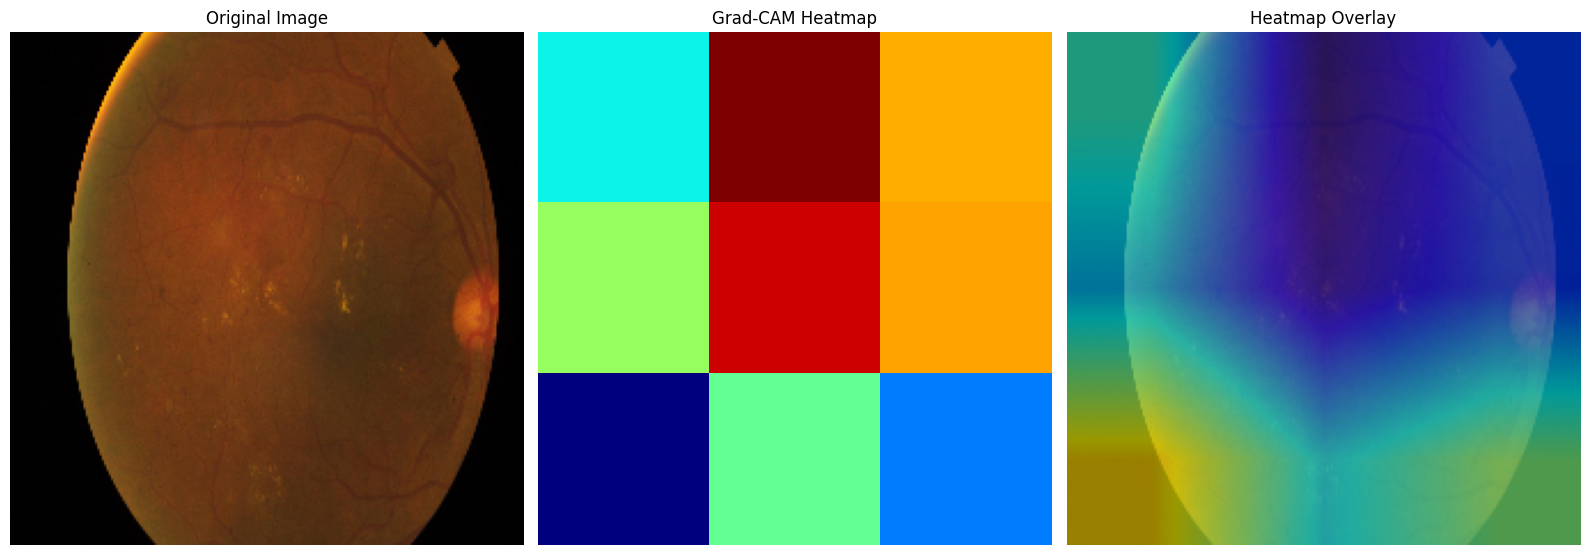

In [27]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

def generate_gradcam_heatmap(model, image, class_idx, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(guided_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap_on_image(heatmap, original_image, alpha=0.6, colormap=cv2.COLORMAP_JET):
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
    overlayed_image = cv2.addWeighted(original_image, 1 - alpha, heatmap_colored, alpha, 0)
    return overlayed_image

# Load and preprocess image
image_path = "/kaggle/input/compa-medical-data-dataset2/compa_multimodal_dataset/retina_data/000c1434d8d7.png"
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image = cv2.resize(original_image, (100, 100)) / 255.0

# Predict class
class_idx = np.argmax(model.predict(np.expand_dims(image, axis=0)))

# ⚠️ For MobileNet, use conv_pw_13_relu
heatmap = generate_gradcam_heatmap(model, image, class_idx, last_conv_layer_name='conv_pw_13_relu')

# Overlay heatmap
overlayed_image = overlay_heatmap_on_image(heatmap, original_image)

# Show results
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlayed_image)
plt.title("Heatmap Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


In [28]:
# Load the saved weights
model.load_weights('/kaggle/working/mobilenet+model.h5')

In [42]:
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop

# Updated class names
class_names = ["Brain_mri_data", "chest_ct_data", "retina_data", "skin_patient_data"]

# Label encoding
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(class_names)
num_classes = len(label_encoder.classes_)

# Load MobileNet base model
mobilenet_model = MobileNet(input_shape=(100, 100, 3), include_top=False, weights='imagenet')

# Custom classifier head
inputs = mobilenet_model.input
conv_output = mobilenet_model.layers[-1].output

x = GlobalAveragePooling2D()(conv_output)
x = Dense(128, kernel_regularizer=l1(0.0001), activation='relu')(x)
x = BatchNormalization(renorm=True)(x)
x = Dropout(0.3)(x)

x = Dense(64, kernel_regularizer=l1(0.0001), activation='relu')(x)
x = BatchNormalization(renorm=True)(x)
x = Dropout(0.3)(x)

x = Dense(32, kernel_regularizer=l1(0.0001), activation='relu')(x)
x = BatchNormalization(renorm=True)(x)
x = Dropout(0.3)(x)

outputs = Dense(units=num_classes, activation='softmax')(x)

# Create and compile the model
model = models.Model(inputs=inputs, outputs=outputs)
custom_optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load trained weights
model.load_weights("/kaggle/working/mobilenet+model.h5")
print("MobileNet model with 4 disease classes loaded successfully!")

# Preprocess image
def preprocess_single_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error loading image: {image_path}")
    
    image = cv2.resize(image, (100, 100))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_enhanced = clahe.apply(gray)
    
    blurred = cv2.GaussianBlur(clahe_enhanced, (5, 5), 0)
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
    
    edges_colored = np.zeros_like(image)
    edges_colored[:, :, 2] = edges
    
    processed_image = cv2.addWeighted(image, 0.8, edges_colored, 0.5, 0)
    
    cv2.imwrite("static/output_image.png", processed_image)
    
    processed_image = processed_image / 255.0
    return np.expand_dims(processed_image, axis=0)

# Prediction
def pred_disease_class(img_path):
    preprocessed_image = preprocess_single_image(img_path)
    predictions = model.predict(preprocessed_image)
    predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])
    pred_prob=[np.argmax(predictions)]
    confidence = np.max(predictions)
    print("prediction array",predictions)
    
    print(f"Predicted Class: {predicted_label[0]}, Confidence: {confidence * 100:.2f}%")
    return predicted_label[0],predictions

# Example usage
pred_disease_class("/kaggle/input/compa-medical-data-dataset2/compa_multimodal_dataset/skin_patient_data/100.jpg")


MobileNet model with 4 disease classes loaded successfully!
1/1 [==============================] - 0s 442ms/step
prediction array [[1.7958904e-04 1.0620632e-04 1.7143339e-04 9.9954271e-01]]
Predicted Class: skin_patient_data, Confidence: 99.95%


('skin_patient_data',
 array([[1.7958904e-04, 1.0620632e-04, 1.7143339e-04, 9.9954271e-01]],
       dtype=float32))

In [1]:
import os
import shutil
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Input and output paths
input_dataset = "/kaggle/input/multimodal-medical-scans-dataset/multimodal_dataset_medical_data"
output_dataset = "/kaggle/working/balanced_dataset"

# Remove old output folder if exists
if os.path.exists(output_dataset):
    shutil.rmtree(output_dataset)
os.makedirs(output_dataset)

# Image augmentation config
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

# Target size and number of images
IMG_SIZE = (100, 100)
TARGET_IMAGES = 500
SUPPORTED_FORMATS = ('.png', '.jpg', '.jpeg')

# Traverse each patient
patient_ids = sorted(os.listdir(input_dataset))

for patient_id in tqdm(patient_ids, desc="Processing Patients"):
    patient_path = os.path.join(input_dataset, patient_id)
    
    if not os.path.isdir(patient_path):
        continue  # Skip if not a folder
    
    modality_folders = os.listdir(patient_path)
    
    for modality in modality_folders:
        modality_path = os.path.join(patient_path, modality)
        
        if not os.path.isdir(modality_path):
            continue
        
        # Get all image paths
        images = [
            os.path.join(modality_path, img)
            for img in os.listdir(modality_path)
            if img.lower().endswith(SUPPORTED_FORMATS)
        ]
        
        if len(images) == 0:
            continue  # No images found
        
        # Create output path
        output_modality_path = os.path.join(output_dataset, patient_id, modality)
        os.makedirs(output_modality_path, exist_ok=True)
        
        # Augmentation loop
        num_images_generated = 0
        image_index = 0

        with tqdm(total=TARGET_IMAGES, desc=f"{patient_id}/{modality}", leave=False) as pbar:
            while num_images_generated < TARGET_IMAGES:
                img_path = images[image_index % len(images)]  # Loop through available images
                try:
                    img = load_img(img_path, target_size=IMG_SIZE)
                except:
                    image_index += 1
                    continue
                
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)

                aug_iter = datagen.flow(img_array, batch_size=1)

                for _ in range(min(TARGET_IMAGES - num_images_generated, 5)):
                    augmented_img = array_to_img(next(aug_iter)[0])
                    augmented_img = augmented_img.resize(IMG_SIZE)
                    save_path = os.path.join(output_modality_path, f"aug_{num_images_generated}.png")
                    augmented_img.save(save_path)
                    num_images_generated += 1
                    pbar.update(1)

                image_index += 1

print("✅ All modalities have been augmented and saved to 'balanced_dataset'.")


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
1/Brain_mri_data:  98%|█████████▊| 491/500 [00:02<00:00, 229.26it/s]
                                                                    
1/skin_patient_data:  98%|█████████▊| 489/500 [00:03<00:00, 128.18it/s]
                                                                       
1/retina_data:  97%|█████████▋| 487/500 [00:04<00:00, 136.25it/s]
                                                                 
10/Brain_mri_data:  99%|█████████▊| 493/500 [00:02<00:00, 217.39it/s]
                                                                     
10/skin_patient_data:  98%|█████████▊| 488/500 [00:03<00:00, 150.26it/s]
                                                                        
10/retina_data:  99%|█████████▉| 494/500 [00:04<00

✅ All modalities have been augmented and saved to 'balanced_dataset'.


In [3]:
import os
import shutil
import uuid
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
import tensorflow as tf
from sklearn.metrics import classification_report

def build_patient_classifier_model(num_classes):
    input_tensor = Input(shape=(224, 224, 3), name="image_input")
    base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet', input_tensor=input_tensor)
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l1(1e-5))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l1(1e-5))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # ⚠️ Output layer without softmax
    output = Dense(num_classes, name="logits_output")(x)

    model = Model(inputs=input_tensor, outputs=output)
    return model

# Paths
dataset_root = '/kaggle/working/balanced_dataset'
modalities = ['Brain_mri_data', 'chest_ct_data', 'retina_data', 'skin_patient_data']
img_size = (224, 224)
batch_size = 32
epochs = 5

# Get patient folders (patient IDs)
patient_folders = sorted([f for f in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, f))])
num_classes = len(patient_folders)

for modality in modalities:
    print(f"\n🔧 Preparing training data for modality: {modality}")
    
    # Temp directory for ImageDataGenerator
    temp_dir = f"temp_data/{modality}"
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
    os.makedirs(temp_dir)

    # Copy each patient's modality images into class-labeled folders (0-9)
    for idx, patient_id in enumerate(patient_folders):
        modality_path = os.path.join(dataset_root, patient_id, modality)
        if not os.path.exists(modality_path):
            continue
        dest_dir = os.path.join(temp_dir, str(idx))
        os.makedirs(dest_dir, exist_ok=True)
        for img_name in os.listdir(modality_path):
            src_path = os.path.join(modality_path, img_name)
            if os.path.isfile(src_path):
                shutil.copy(src_path, os.path.join(dest_dir, f"{uuid.uuid4().hex}.jpg"))

    # Setup data generators
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen = datagen.flow_from_directory(
        temp_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    val_gen = datagen.flow_from_directory(
        temp_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    # Build and compile model
    print(f"🚀 Training model for modality: {modality}")
    model = build_patient_classifier_model(num_classes)
    
    # ⚠️ Use from_logits=True since we removed softmax
    model.compile(
        optimizer=Adam(1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Train the model
    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=len(train_gen),
        validation_steps=len(val_gen)
    )

    # Save model (logits output)
    model.save(f"patient_model_{modality}.h5")
    print(f"✅ Saved model: patient_model_{modality}.h5")

    # 📊 Classification Report
    val_gen.reset()
    logits = model.predict(val_gen, steps=len(val_gen), verbose=1)
    y_pred = np.argmax(logits, axis=1)
    y_true = val_gen.classes
    class_labels = list(val_gen.class_indices.keys())

    print(f"\n📊 Classification Report for modality: {modality}")
    report = classification_report(y_true, y_pred, target_names=class_labels)
    print(report)

    # Cleanup
    shutil.rmtree(temp_dir)



🔧 Preparing training data for modality: Brain_mri_data
Found 4000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
🚀 Training model for modality: Brain_mri_data
Epoch 1/5
125/125 [==============================] - 25s 93ms/step - loss: 1.1770 - accuracy: 0.6310 - val_loss: 1.5374 - val_accuracy: 0.4800
Epoch 2/5
125/125 [==============================] - 11s 85ms/step - loss: 0.4732 - accuracy: 0.8802 - val_loss: 0.7519 - val_accuracy: 0.7550
Epoch 3/5
125/125 [==============================] - 11s 86ms/step - loss: 0.3145 - accuracy: 0.9377 - val_loss: 0.3499 - val_accuracy: 0.9150
Epoch 4/5
125/125 [==============================] - 11s 88ms/step - loss: 0.2291 - accuracy: 0.9632 - val_loss: 0.2497 - val_accuracy: 0.9550
Epoch 5/5
125/125 [==============================] - 11s 87ms/step - loss: 0.1818 - accuracy: 0.9805 - val_loss: 0.1445 - val_accuracy: 0.9820


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Saved model: patient_model_Brain_mri_data.h5
32/32 [==============================] - 2s 48ms/step

📊 Classification Report for modality: Brain_mri_data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.97      0.99      0.98       100
           2       0.94      0.99      0.97       100
           3       1.00      0.99      0.99       100
           4       0.97      0.97      0.97       100
           5       0.98      0.98      0.98       100
           6       1.00      1.00      1.00       100
           7       0.98      0.98      0.98       100
           8       0.99      0.94      0.96       100
           9       0.99      0.98      0.98       100

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


🔧 Preparing training data for modality: chest_ct_data
Found 4000 images belonging to 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Saved model: patient_model_chest_ct_data.h5
32/32 [==============================] - 2s 46ms/step

📊 Classification Report for modality: chest_ct_data
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       100
           1       1.00      1.00      1.00       100
           2       1.00      0.98      0.99       100
           3       0.98      0.97      0.97       100
           4       1.00      1.00      1.00       100
           5       0.97      1.00      0.99       100
           6       1.00      1.00      1.00       100
           7       1.00      0.99      0.99       100
           8       1.00      1.00      1.00       100
           9       1.00      1.00      1.00       100

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000


🔧 Preparing training data for modality: retina_data
Found 4000 images belonging to 10 c

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Saved model: patient_model_retina_data.h5
32/32 [==============================] - 2s 43ms/step

📊 Classification Report for modality: retina_data
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       100
           1       0.83      0.91      0.87       100
           2       0.91      0.79      0.84       100
           3       0.86      0.93      0.89       100
           4       1.00      0.78      0.88       100
           5       0.84      0.82      0.83       100
           6       0.92      0.98      0.95       100
           7       0.99      1.00      1.00       100
           8       1.00      1.00      1.00       100
           9       0.97      0.93      0.95       100

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000


🔧 Preparing training data for modality: skin_patient_data
Found 4000 images belonging to 10

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Saved model: patient_model_skin_patient_data.h5
32/32 [==============================] - 2s 50ms/step

📊 Classification Report for modality: skin_patient_data
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       100
           1       0.88      0.84      0.86       100
           2       0.81      0.91      0.85       100
           3       0.92      0.97      0.95       100
           4       0.80      0.99      0.88       100
           5       0.90      0.94      0.92       100
           6       1.00      0.84      0.91       100
           7       0.98      0.92      0.95       100
           8       0.93      0.80      0.86       100
           9       0.85      0.83      0.84       100

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [5]:
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop

In [6]:
model = load_model("patient_model_Brain_mri_data.h5")
img = load_img("/kaggle/working/balanced_dataset/10/Brain_mri_data/aug_104.png", target_size=(224, 224))
x = img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)
logits = model.predict(x)
print(logits)


1/1 [==============================] - 1s 574ms/step
[[ 0.73179406  6.392093   -0.39617902 -3.396346   -0.30074167 -0.34041893
  -1.5025296  -1.1099273  -1.5809613  -2.5083177 ]]


In [7]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load single model
modality = 'Brain_mri_data'
model_path = f"patient_model_{modality}.h5"

print(f"📦 Loading model: {modality}")
model = load_model(model_path, compile=False)
print(f"📏 Expected Input Shape: {model.input_shape}")

# Inputs
image_input = Input(shape=(224, 224, 3), name="image_input")

# Get logits
logits = model(image_input)

# Final model
final_model = Model(inputs=image_input, outputs=logits)
final_model.summary()

# Test prediction
image_path = "/kaggle/working/balanced_dataset/10/Brain_mri_data/aug_104.png"
x = load_img(image_path, target_size=(224, 224))
x = img_to_array(x) / 255.0
x = np.expand_dims(x, axis=0)

logits = final_model.predict(x)
probs = tf.nn.softmax(logits).numpy()

print("🔍 Raw logits:", logits)
print("🔥 Softmax probabilities:", probs)
print("🧠 Predicted Patient ID:", np.argmax(probs))

📦 Loading model: Brain_mri_data
📏 Expected Input Shape: (None, 224, 224, 3)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 10)                3369738   
                                                                 
Total params: 3369738 (12.85 MB)
Trainable params: 3347466 (12.77 MB)
Non-trainable params: 22272 (87.00 KB)
_________________________________________________________________
1/1 [==============================] - 0s 429ms/step
🔍 Raw logits: [[ 0.73179406  6.392093   -0.39617902 -3.396346   -0.30074167 -0.34041893
  -1.5025296  -1.1099273  -1.5809613  -2.5083177 ]]
🔥 Softmax probabilities: [[3.4521266e-03 9.9157012e-01 1.1174142e-03 5.5623521e-05 1.2293122e-03
  1.1814917e-03 3.6960028e-04 5.4731505e-04 3.

In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

modalities = ['Brain_mri_data', 'chest_ct_data', 'retina_data', 'skin_patient_data']
num_classes = 10
model_paths = {mod: f"patient_model_{mod}.h5" for mod in modalities}

# Preprocess function
def preprocess_image(image_path, modality):
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    if modality == 'Brain_mri_data':
        x = x / 255.0
    elif modality == 'chest_ct_data':
        x = (x - np.mean(x)) / np.std(x)
    elif modality == 'retina_data':
        x = x / 255.0
    elif modality == 'skin_patient_data':
        x = x / 255.0
    else:
        raise ValueError(f"Unknown modality: {modality}")
    return np.expand_dims(x, axis=0)

# Inputs
image_input = Input(shape=(224, 224, 3), name="image_input")
modality_weights = Input(shape=(len(modalities),), name="modality_weights")

modality_outputs = []

for idx, modality in enumerate(modalities):
    print(f"📦 Loading model: {modality}")
    model = load_model(model_paths[modality], compile=False)
    print(f"📏 {modality} Expected Input Shape: {model.input_shape}")
    
    # Get logits
    logits = model(image_input)
    print(f"🔍 {modality} Logits Shape: {logits.shape}")
    
    # Apply weight
    weight = Lambda(lambda w, i=idx: tf.expand_dims(w[:, i], axis=-1), name=f"{modality}_weight")(modality_weights)
    weighted_logits = Lambda(lambda x: x[0] * x[1], name=f"{modality}_weighted")([logits, weight])
    modality_outputs.append(weighted_logits)

# Sum weighted logits
combined_logits = Lambda(lambda x: tf.reduce_sum(x, axis=0), name="combined_logits")(modality_outputs)
print(f"🔍 Combined Logits Shape: {combined_logits.shape}")

# Final model
final_model = Model(inputs=[image_input, modality_weights], outputs=combined_logits)
final_model.summary()

# Test prediction
image_path = "/kaggle/working/balanced_dataset/10/Brain_mri_data/aug_104.png"
x = preprocess_image(image_path, "Brain_mri_data")
weight_vector = np.zeros((1, len(modalities)))
weight_vector[0][modalities.index("Brain_mri_data")] = 1.0
print(f"⚖️ Weight Vector: {weight_vector}")

logits = final_model.predict([x, weight_vector])
probs = tf.nn.softmax(logits).numpy()

print("🔍 Raw logits:", logits)
print("🔥 Softmax probabilities:", probs)
print("🧠 Predicted Patient ID:", np.argmax(probs))

# Save if successful
final_model.save("final_multimodal_patient_model_fixed.h5")
print("✅ Saved: final_multimodal_patient_model_fixed.h5")

📦 Loading model: Brain_mri_data
📏 Brain_mri_data Expected Input Shape: (None, 224, 224, 3)
🔍 Brain_mri_data Logits Shape: (None, 10)
📦 Loading model: chest_ct_data
📏 chest_ct_data Expected Input Shape: (None, 224, 224, 3)
🔍 chest_ct_data Logits Shape: (None, 10)
📦 Loading model: retina_data
📏 retina_data Expected Input Shape: (None, 224, 224, 3)
🔍 retina_data Logits Shape: (None, 10)
📦 Loading model: skin_patient_data
📏 skin_patient_data Expected Input Shape: (None, 224, 224, 3)
🔍 skin_patient_data Logits Shape: (None, 10)
🔍 Combined Logits Shape: (None, 10)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 modality_weights (Inp

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Saved: final_multimodal_patient_model_fixed.h5


In [9]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define modalities
modalities = ['Brain_mri_data', 'chest_ct_data', 'retina_data', 'skin_patient_data']

# Preprocess function (same as before)
def preprocess_image(image_path, modality):
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    if modality == 'Brain_mri_data':
        x = x / 255.0
    elif modality == 'chest_ct_data':
        x = (x - np.mean(x)) / np.std(x)
    elif modality == 'retina_data':
        x = x / 255.0
    elif modality == 'skin_patient_data':
        x = x / 255.0
    else:
        raise ValueError(f"Unknown modality: {modality}")
    return np.expand_dims(x, axis=0)

# Load the saved model
model = load_model("final_multimodal_patient_model_fixed.h5", compile=False)
print("✅ Loaded model: final_multimodal_patient_model_fixed.h5")

# Prediction function
def predict_patient(image_path, modality_name):
    if modality_name not in modalities:
        raise ValueError(f"Modality {modality_name} not in {modalities}")
    
    # Preprocess image
    x = preprocess_image(image_path, modality_name)
    
    # Create weight vector
    weight_vector = np.zeros((1, len(modalities)))
    weight_vector[0][modalities.index(modality_name)] = 1.0
    print(f"⚖️ Weight Vector: {weight_vector}")
    
    # Predict
    logits = model.predict([x, weight_vector])
    probs = tf.nn.softmax(logits).numpy()
    
    print("🔍 Raw logits:", logits)
    print("🔥 Softmax probabilities:", probs)
    print("🧠 Predicted Patient ID:", np.argmax(probs))
    return np.argmax(probs)

# Test prediction
image_path = "/kaggle/working/balanced_dataset/5/Brain_mri_data/aug_1.png"
predict_patient(image_path, "Brain_mri_data")

✅ Loaded model: final_multimodal_patient_model_fixed.h5
⚖️ Weight Vector: [[1. 0. 0. 0.]]
1/1 [==============================] - 2s 2s/step
🔍 Raw logits: [[-0.5801616  -2.42729    -2.0527856  -0.24402098 -2.745333    6.378458
  -0.8592382  -0.17256033 -1.9565601  -1.0069339 ]]
🔥 Softmax probabilities: [[9.4495964e-04 1.4901005e-04 2.1670086e-04 1.3225049e-03 1.0841551e-04
  9.9426770e-01 7.1484491e-04 1.4204707e-03 2.3858927e-04 6.1669189e-04]]
🧠 Predicted Patient ID: 5


5

In [10]:
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop

# Updated class names
class_names = ["Brain_mri_data", "chest_ct_data", "retina_data", "skin_patient_data"]

# Label encoding
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(class_names)
num_classes = len(label_encoder.classes_)

# Load MobileNet base model
mobilenet_model = MobileNet(input_shape=(100, 100, 3), include_top=False, weights='imagenet')

# Custom classifier head
inputs = mobilenet_model.input
conv_output = mobilenet_model.layers[-1].output

x = GlobalAveragePooling2D()(conv_output)
x = Dense(128, kernel_regularizer=l1(0.0001), activation='relu')(x)
x = BatchNormalization(renorm=True)(x)
x = Dropout(0.3)(x)

x = Dense(64, kernel_regularizer=l1(0.0001), activation='relu')(x)
x = BatchNormalization(renorm=True)(x)
x = Dropout(0.3)(x)

x = Dense(32, kernel_regularizer=l1(0.0001), activation='relu')(x)
x = BatchNormalization(renorm=True)(x)
x = Dropout(0.3)(x)

outputs = Dense(units=num_classes, activation='softmax')(x)

# Create and compile the model
model = models.Model(inputs=inputs, outputs=outputs)
custom_optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load trained weights
model.load_weights("/kaggle/input/compa_model/keras/default/1/mobilenetmodel.h5")
print("MobileNet model with 4 disease classes loaded successfully!")

# Preprocess image
def preprocess_single_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error loading image: {image_path}")
    
    image = cv2.resize(image, (100, 100))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_enhanced = clahe.apply(gray)
    
    blurred = cv2.GaussianBlur(clahe_enhanced, (5, 5), 0)
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
    
    edges_colored = np.zeros_like(image)
    edges_colored[:, :, 2] = edges
    
    processed_image = cv2.addWeighted(image, 0.8, edges_colored, 0.5, 0)
    
    cv2.imwrite("static/output_image.png", processed_image)
    
    processed_image = processed_image / 255.0
    return np.expand_dims(processed_image, axis=0)

# Prediction
def pred_disease_class(img_path):
    preprocessed_image = preprocess_single_image(img_path)
    predictions = model.predict(preprocessed_image)
    predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])
    pred_prob=[np.argmax(predictions)]
    confidence = np.max(predictions)
    print("prediction array",predictions)
    
    print(f"Predicted Class: {predicted_label[0]}, Confidence: {confidence * 100:.2f}%")
    return predicted_label[0],predictions

# Example usage
pred_disease_class("/kaggle/working/balanced_dataset/5/Brain_mri_data/aug_1.png")


MobileNet model with 4 disease classes loaded successfully!
1/1 [==============================] - 1s 617ms/step
prediction array [[9.9929607e-01 1.3797480e-04 3.6266024e-04 2.0331700e-04]]
Predicted Class: Brain_mri_data, Confidence: 99.93%


('Brain_mri_data',
 array([[9.9929607e-01, 1.3797480e-04, 3.6266024e-04, 2.0331700e-04]],
       dtype=float32))

In [11]:
pred_disease_class("/kaggle/working/balanced_dataset/5/Brain_mri_data/aug_1.png")

1/1 [==============================] - 0s 20ms/step
prediction array [[9.9929607e-01 1.3797480e-04 3.6266024e-04 2.0331700e-04]]
Predicted Class: Brain_mri_data, Confidence: 99.93%


('Brain_mri_data',
 array([[9.9929607e-01, 1.3797480e-04, 3.6266024e-04, 2.0331700e-04]],
       dtype=float32))

In [12]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define modalities
modalities = ['Brain_mri_data', 'chest_ct_data', 'retina_data', 'skin_patient_data']

# Preprocess function (same as before)
def preprocess_image(image_path, modality):
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    if modality == 'Brain_mri_data':
        x = x / 255.0
    elif modality == 'chest_ct_data':
        x = (x - np.mean(x)) / np.std(x)
    elif modality == 'retina_data':
        x = x / 255.0
    elif modality == 'skin_patient_data':
        x = x / 255.0
    else:
        raise ValueError(f"Unknown modality: {modality}")
    return np.expand_dims(x, axis=0)

# Load the saved model
model2 = load_model("final_multimodal_patient_model_fixed.h5", compile=False)
print("✅ Loaded model: final_multimodal_patient_model_fixed.h5")

# Prediction function
def predict_patient(image_path, modality_name):
    if modality_name not in modalities:
        raise ValueError(f"Modality {modality_name} not in {modalities}")
    
    # Preprocess image
    x = preprocess_image(image_path, modality_name)
    
    # Create weight vector
    weight_vector = np.zeros((1, len(modalities)))
    weight_vector[0][modalities.index(modality_name)] = 1.0
    print(f"⚖️ Weight Vector: {weight_vector}")
    
    # Predict
    logits = model2.predict([x, weight_vector])
    probs = tf.nn.softmax(logits).numpy()
    
    print("🔍 Raw logits:", logits)
    print("🔥 Softmax probabilities:", probs)
    print("🧠 Predicted Patient ID:", np.argmax(probs))
    return np.argmax(probs)

# Test prediction
image_path = "/kaggle/working/balanced_dataset/5/Brain_mri_data/aug_1.png"

modality_name,confidence_score=pred_disease_class("/kaggle/working/balanced_dataset/5/Brain_mri_data/aug_1.png")
predict_patient(image_path, modality_name)

✅ Loaded model: final_multimodal_patient_model_fixed.h5
1/1 [==============================] - 0s 21ms/step
prediction array [[9.9929607e-01 1.3797480e-04 3.6266024e-04 2.0331700e-04]]
Predicted Class: Brain_mri_data, Confidence: 99.93%
⚖️ Weight Vector: [[1. 0. 0. 0.]]
1/1 [==============================] - 2s 2s/step
🔍 Raw logits: [[-0.5801616  -2.42729    -2.0527856  -0.24402098 -2.745333    6.378458
  -0.8592382  -0.17256033 -1.9565601  -1.0069339 ]]
🔥 Softmax probabilities: [[9.4495964e-04 1.4901005e-04 2.1670086e-04 1.3225049e-03 1.0841551e-04
  9.9426770e-01 7.1484491e-04 1.4204707e-03 2.3858927e-04 6.1669189e-04]]
🧠 Predicted Patient ID: 5


5

In [13]:
# 📌 Function to test if two images belong to the same patient
def compare_patients(image_path1, image_path2):
    # Step 1: Get predicted modality and confidence for both images
    modality1, confidence1 = pred_disease_class(image_path1)
    modality2, confidence2 = pred_disease_class(image_path2)

    # Step 2: Get predicted patient ID for both images
    patient_id1 = predict_patient(image_path1, modality1)
    patient_id2 = predict_patient(image_path2, modality2)

    # Step 3: Compare patient IDs
    print(f"📸 Image 1 predicted patient ID: {patient_id1}")
    print(f"📸 Image 2 predicted patient ID: {patient_id2}")

    if patient_id1 == patient_id2:
        print("✅ Both images belong to the same patient.")
        return True
    else:
        print("❌ Images belong to different patients.")
        return False

# 🔍 Example test
image_path1 = "/kaggle/working/balanced_dataset/5/Brain_mri_data/aug_1.png"
image_path2 = "/kaggle/working/balanced_dataset/5/skin_patient_data/aug_100.png"

compare_patients(image_path1, image_path2)


1/1 [==============================] - 0s 20ms/step
prediction array [[9.9929607e-01 1.3797480e-04 3.6266024e-04 2.0331700e-04]]
Predicted Class: Brain_mri_data, Confidence: 99.93%
1/1 [==============================] - 0s 18ms/step
prediction array [[4.1899964e-04 1.5963119e-04 5.8813422e-04 9.9883324e-01]]
Predicted Class: skin_patient_data, Confidence: 99.88%
⚖️ Weight Vector: [[1. 0. 0. 0.]]
1/1 [==============================] - 0s 25ms/step
🔍 Raw logits: [[-0.5801616  -2.42729    -2.0527856  -0.24402098 -2.745333    6.378458
  -0.8592382  -0.17256033 -1.9565601  -1.0069339 ]]
🔥 Softmax probabilities: [[9.4495964e-04 1.4901005e-04 2.1670086e-04 1.3225049e-03 1.0841551e-04
  9.9426770e-01 7.1484491e-04 1.4204707e-03 2.3858927e-04 6.1669189e-04]]
🧠 Predicted Patient ID: 5
⚖️ Weight Vector: [[0. 0. 0. 1.]]
1/1 [==============================] - 0s 25ms/step
🔍 Raw logits: [[-1.3511765  -0.69315076 -0.5644413   0.1192261  -0.02120415  5.4555116
  -1.139377   -0.47250128  1.2724085  -0.

True